In [1]:
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.EEG_Tensorflow_models

  Cloning https://github.com/UN-GCPDS/python-gcpds.EEG_Tensorflow_models to /tmp/pip-req-build-s6y05ray
  Running command git clone --filter=blob:none --quiet https://github.com/UN-GCPDS/python-gcpds.EEG_Tensorflow_models /tmp/pip-req-build-s6y05ray
  Resolved https://github.com/UN-GCPDS/python-gcpds.EEG_Tensorflow_models to commit 975885b1f6814fd5958199919b33e02a6a9aa152
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.4/184.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.7/234.7 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 83.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Lambda, Reshape, Conv2DTranspose, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models, initializers,regularizers
from tensorflow.keras.losses import binary_crossentropy
# from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from keras.losses import MeanSquaredError
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib as mpl
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

from matplotlib import cm
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tensorflow.keras.losses import Loss
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
#(batch_size, 28, 28, 1)
X_train = np.expand_dims(X_train, -1)
X_valid = np.expand_dims(X_valid, -1)

# One-hot encoding
num_classes = 10
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_valid_one_hot = tf.keras.utils.to_categorical(y_valid, num_classes=num_classes)

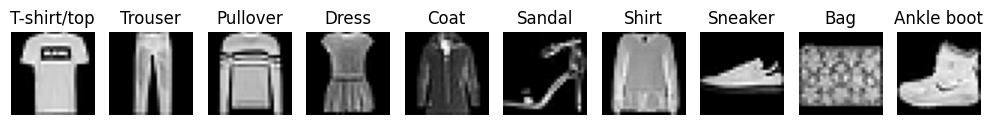

In [5]:
plt.figure(figsize=(10, 5))

# Etiquetas 
categories = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


for i in range(10):
    # Encontrar el primer ejemplo de la categoría actual
    example_index = np.where(y_train == i)[0][0]
    image = X_train[example_index]
    
    # Configurar un subgráfico para cada categoría
    plt.subplot(1, 10, i + 1)  # 2 filas, 5 columnas
    plt.imshow(image, cmap='gray')
    plt.title(categories[i])
    plt.axis('off') 

plt.tight_layout()
plt.show()

In [6]:
@tf.keras.utils.register_keras_serializable()
class Sampling(tf.keras.layers.Layer):
    """
    Capa de muestreo para el truco de reparametrización en Autoencoders Variacionales (VAEs).

    Esta capa se utiliza para muestrear un vector latente `z` a partir de la distribución
    definida por la media (`z_mean`) y la varianza logarítmica (`z_log_var`) de una 
    distribución normal. El truco de reparametrización asegura que se pueda aplicar 
    retropropagación a través del paso estocástico de muestreo.

    Usa la siguiente fórmula:
        z = z_mean + exp(0.5 * z_log_var) * epsilon
    donde epsilon es una variable aleatoria normal tomada de una distribución normal estándar.

    Métodos:
    --------
    call(inputs):
        Este método realiza la operación de muestreo tomando `z_mean` y `z_log_var` como 
        entrada y devolviendo el vector latente `z` muestreado.

    Parámetros:
    -----------
    inputs : tupla de tensores
        Una tupla `(z_mean, z_log_var)` donde:
        - `z_mean`: Tensor de forma `(batch_size, latent_dim)` que representa la media de la distribución.
        - `z_log_var`: Tensor de forma `(batch_size, latent_dim)` que representa el logaritmo de la varianza de la distribución.

    Retorno:
    --------
    Tensor:
        Un tensor `z` de la misma forma que `z_mean`, que representa el vector latente muestreado.
    """
    
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [7]:
def plot_mnist_autoencoder(x, x_, y=None, y_=None, cmap='gray', vmin=0, vmax=1):
    """
    Grafica las imágenes originales y reconstruidas de MNIST usando un autoencoder, incluyendo las etiquetas.

    Parámetros:
    -----------
    x : Sequence[np.ndarray]
        Imágenes originales.
    x_ : Sequence[np.ndarray]
        Imágenes reconstruidas por el autoencoder.
    y : Optional[Sequence], opcional
        Etiquetas verdaderas de las imágenes, por defecto None.
    y_ : Optional[Sequence], opcional
        Etiquetas predichas por el modelo (si aplica), por defecto None.
    cmap : str, opcional
        Mapa de colores para las imágenes, por defecto 'gray'.
    vmin : float, opcional
        Valor mínimo para la normalización de la imagen, por defecto 0.
    vmax : float, opcional
        Valor máximo para la normalización de la imagen, por defecto 1.

    Descripción:
    ------------
    Esta función grafica dos filas de imágenes: la primera fila contiene las imágenes originales y la segunda fila 
    contiene las imágenes reconstruidas por el autoencoder. Si se proporcionan etiquetas, también muestra las 
    etiquetas verdaderas y predichas en los títulos de las imágenes. Las etiquetas predichas se colorean de verde 
    si coinciden con las etiquetas verdaderas, o de rojo si no coinciden.

    Cada imagen se normaliza entre `vmin` y `vmax`, y se puede personalizar el mapa de colores utilizando el parámetro `cmap`.
    
    Uso:
    ----
    Esta función es útil para evaluar visualmente el rendimiento de un autoencoder, comparando las imágenes 
    originales con las imágenes reconstruidas por el modelo.
    """
    plt.figure(figsize=(20, 4))
    num_images = len(x)
    
    for i in range(num_images):
        # Mostrar imagen original
        plt.subplot(2, num_images, i + 1)
        plt.imshow(x[i].reshape(28, 28), cmap=cmap, vmin=vmin, vmax=vmax)
        if y is not None:
            plt.title(f'Verdadero: {y[i]}')
        plt.axis('off')
        
        # Mostrar imagen reconstruida
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(x_[i].reshape(28, 28), cmap=cmap, vmin=vmin, vmax=vmax)
        if y_ is not None:
            color = "red" if y is not None and y[i] != y_[i] else 'green'
            plt.title(f'Predicho: {y_[i]}', color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [8]:
def compare_images(original_images, predicted_images, true_labels, label_names, indices, figsize=(10, 5)):
    """
    Función para comparar visualmente imágenes originales con las predicciones, mostrando también las etiquetas verdaderas.
    Args:
    original_images (numpy.array): Array de imágenes originales.
    predicted_images (numpy.array): Array de imágenes reconstruidas por el modelo, con la forma (n_samples, height, width, channels).
    true_labels (numpy.array): Array de etiquetas verdaderas para las imágenes originales.
    label_names (list): Lista de nombres de etiquetas correspondientes a las clases.
    indices (list of int): Lista de índices de las imágenes a comparar.
    figsize (tuple): Tamaño de la figura de matplotlib.
    """
    plt.figure(figsize=figsize)
    num_images = len(indices)

    for i, index in enumerate(indices):
        # Mostrar imagen original
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original_images[index].squeeze(), cmap='gray')
        plt.title(f'Original {index}\nLabel: {label_names[true_labels[index]]}')
        plt.axis('off')

        # Mostrar imagen predicha
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(predicted_images[index].squeeze(), cmap='gray')
        plt.title(f'Reconstrucción {index}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [9]:
# Funciones de pérdida
def reconstruction_loss(y_true, y_pred):
    y_true_flat = tf.keras.backend.flatten(y_true)
    y_pred_flat = tf.keras.backend.flatten(y_pred)
    return tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true_flat, y_pred_flat))

def dkl_loss(y_true, y_pred):
    # y_pred es z_gaussian
    latent_dim = y_pred.shape[1] // 2
    z_mean = y_pred[:, :latent_dim]
    z_log_var = y_pred[:, latent_dim:]
    return -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))

# Criterio de dependencia usando imágenes y etiquetas predichas
def dependency_criterion(images, predicted_labels):
    """
    Calcula el criterio de dependencia entre las imágenes y las etiquetas predichas.
    
    Args:
    images (tensor): Imágenes de entrada del modelo.
    predicted_labels (tensor): Etiquetas predichas por el modelo.
    
    Returns:
    loss (tensor): La pérdida basada en la dependencia entre imágenes y etiquetas.
    """
    # Calcular la media de las imágenes y las etiquetas predichas
    f_mean = K.mean(images, axis=0)
    g_mean = K.mean(predicted_labels, axis=0)
    
    # Centramos las imágenes y las etiquetas predichas
    f_centered = images - f_mean
    g_centered = predicted_labels - g_mean
    
    # Calculamos la covarianza cruzada
    batch_size = tf.cast(tf.shape(images)[0], tf.float32)
    cov_xy = K.dot(K.transpose(f_centered), g_centered) / batch_size
    
    # Maximizar <g, Cxy f>
    loss = -tf.reduce_sum(tf.linalg.diag_part(cov_xy))  # Minimizar el negativo de la traza de la covarianza
    
    return loss


In [10]:
# Definir el modelo
def model_class(input_shape=(28, 28, 1), num_classes=10, latent_dim=128):
    """
    Define un modelo de autoencoder variacional (VAE) con un clasificador softmax incorporado.
    El modelo consta de un codificador (encoder) para generar una representación latente, y un decodificador (decoder)
    que reconstruye las imágenes desde esa representación latente, junto con una salida de clasificación.

    Parámetros
    ----------
    input_shape : tuple, opcional
        Forma de la entrada de las imágenes, en este caso imágenes MNIST de tamaño 28x28 con un canal de color (escala de grises).
        Valor predeterminado: (28, 28, 1).
    num_classes : int, opcional
        Número de clases para la clasificación. Para MNIST son 10 clases (dígitos del 0 al 9). Valor predeterminado: 10.
    latent_dim : int, opcional
        Dimensión del espacio latente donde se mapean las imágenes después del encoder. Valor predeterminado: 128.

    Returns
    -------
    vae : tf.keras.Model
        Un modelo Keras que representa el autoencoder variacional (VAE) con tres salidas: la reconstrucción de la imagen,
        los parámetros latentes (media y logaritmo de la varianza), y la salida softmax para la clasificación.

    Descripción
    -----------
    El modelo consta de las siguientes secciones:
    
    1. **Encoder**:
       - Capas convolucionales (`Conv2D`) para extraer características de las imágenes de entrada.
       - `AveragePooling2D` para reducir las dimensiones espaciales.
       - `Dropout` para evitar el sobreajuste.
       - Capas densas para calcular la media (`z_mean`) y el logaritmo de la varianza (`z_log_var`) de la distribución latente.
       - La capa personalizada `Sampling` que usa el truco de reparametrización para muestrear del espacio latente.

    2. **Decoder**:
       - Capas densas y de `Conv2DTranspose` para reconstruir las imágenes a partir de la representación latente.
       - `UpSampling2D` para aumentar las dimensiones espaciales.
       - La salida de reconstrucción es una imagen reconstruida de la misma forma que la entrada original.

    3. **Clasificación**:
       - Una capa `Dense` con activación `softmax` que genera una salida de clasificación.


    """
    # Encoder
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(6, kernel_size=3, activation='selu',
                               kernel_initializer=tf.keras.initializers.GlorotUniform(seed=12),
                               padding='same', name='conv1')(inputs)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.15)(x)
    x = tf.keras.layers.Conv2D(16, kernel_size=3, activation='selu',
                               kernel_initializer=tf.keras.initializers.GlorotUniform(seed=23),
                               padding='same', name='conv2')(x)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = tf.keras.layers.Conv2D(120, kernel_size=3, activation='selu',
                               kernel_initializer=tf.keras.initializers.GlorotUniform(seed=52),
                               padding='same', name='conv3')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.15)(x)

    # Definir las capas de la representación latente
    z_mean = tf.keras.layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = tf.keras.layers.Dense(latent_dim, name='z_log_var')(x)
    z_gaussian = tf.keras.layers.Concatenate(name='z_gaussian', axis=-1)([z_mean, z_log_var])
    z = Sampling()([z_mean, z_log_var])  # Muestreo utilizando reparametrización

    # Capa de clasificación softmax
    softmax_output = tf.keras.layers.Dense(num_classes, activation='softmax', name='softmax_output')(z)

    # Decoder
    x = tf.keras.layers.Dense(7 * 7 * 16, activation='selu')(z)
    x = tf.keras.layers.Reshape((7, 7, 16))(x)
    x = tf.keras.layers.Conv2DTranspose(16, kernel_size=3, activation='selu',
                                        kernel_initializer=tf.keras.initializers.GlorotUniform(seed=12),
                                        padding='same')(x)
    x = tf.keras.layers.Dropout(0.15)(x)
    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    x = tf.keras.layers.Conv2DTranspose(6, kernel_size=3, activation='selu',
                                        kernel_initializer=tf.keras.initializers.GlorotUniform(seed=23),
                                        padding='same', name='conv2Transpose')(x)
    x = tf.keras.layers.Dropout(0.15)(x)
    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)

    # Reconstrucción final de la imagen
    reconstruction = tf.keras.layers.Conv2D(input_shape[2], kernel_size=3, padding='same',
                                            activation='sigmoid', name='reconstruction')(x)

    # Definir el modelo VAE con tres salidas
    vae = tf.keras.models.Model(inputs, [reconstruction, z_gaussian, softmax_output], name='vae')
    return vae


# Construir y compilar el modelo
input_shape = (28, 28, 1)
num_classes = 10
latent_dim = 64
learning_rate = 1e-3

# Crear el modelo utilizando la clase definida
model = model_class(input_shape, num_classes, latent_dim)

# Definir y compilar el modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss={'reconstruction': reconstruction_loss,  # Pérdida de reconstrucción
                    'z_gaussian': dkl_loss,  # Divergencia KL para las variables latentes
                    'softmax_output': dependency_criterion},  # Pérdida de clasificación
              loss_weights={'reconstruction': 0.5,
                            'z_gaussian': 0.1,
                            'softmax_output': 0.4},  # Ajuste de los pesos de las pérdidas
              metrics={'reconstruction': [reconstruction_loss],  # Métricas de reconstrucción
                       'z_gaussian': [dkl_loss],  # Métricas para la distribución latente
                       'softmax_output': [dependency_criterion]}  # Métricas de clasificación
             )
"""
    Este bloque compila el modelo VAE definido anteriormente con un optimizador Adam y las pérdidas asignadas para 
    cada una de las salidas del modelo:

    - **Reconstrucción**: Usa la función de pérdida `reconstruction_loss` para medir la diferencia entre la imagen original y la reconstruida.
    - **Distribución Gaussiana**: Usa `dkl_loss` para penalizar la divergencia KL entre la distribución latente aprendida y una distribución gaussiana estándar.
    - **Clasificación Softmax**: Usa `dependency_criterion` como la función de pérdida para la salida de clasificación.

    Parámetros
    ----------
    optimizer : tf.keras.optimizers.Optimizer
        El optimizador utilizado. En este caso, es Adam con una tasa de aprendizaje de 1e-3.
    loss : dict
        Un diccionario que mapea las salidas del modelo con sus respectivas funciones de pérdida.
    loss_weights : dict
        Un diccionario que asigna pesos a cada una de las pérdidas para balancearlas durante el entrenamiento.
    metrics : dict
        Un diccionario que mapea las métricas de evaluación para cada salida del modelo.
"""


'\n    Este bloque compila el modelo VAE definido anteriormente con un optimizador Adam y las pérdidas asignadas para \n    cada una de las salidas del modelo:\n\n    - **Reconstrucción**: Usa la función de pérdida `reconstruction_loss` para medir la diferencia entre la imagen original y la reconstruida.\n    - **Distribución Gaussiana**: Usa `dkl_loss` para penalizar la divergencia KL entre la distribución latente aprendida y una distribución gaussiana estándar.\n    - **Clasificación Softmax**: Usa `dependency_criterion` como la función de pérdida para la salida de clasificación.\n\n    Parámetros\n    ----------\n    optimizer : tf.keras.optimizers.Optimizer\n        El optimizador utilizado. En este caso, es Adam con una tasa de aprendizaje de 1e-3.\n    loss : dict\n        Un diccionario que mapea las salidas del modelo con sus respectivas funciones de pérdida.\n    loss_weights : dict\n        Un diccionario que asigna pesos a cada una de las pérdidas para balancearlas durante e

In [11]:
seed = 42
epochs = 118
batch_size = 32
learning_rate =1e-2

In [12]:
history = model.fit(X_train,
                    [X_train, X_train, y_train_one_hot],
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_valid, [X_valid, X_valid, y_valid_one_hot])
                   )

Epoch 1/118


I0000 00:00:1728397562.913029     147 service.cc:145] XLA service 0x7c94b8006720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728397562.913071     147 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1728397562.913075     147 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  40/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.2570 - reconstruction_reconstruction_loss: 0.6194 - softmax_output_dependency_criterion: -0.2142 - z_gaussian_dkl_loss: 0.3295  

I0000 00:00:1728397572.854850     147 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 33s 11ms/step - loss: 0.0017 - reconstruction_reconstruction_loss: 0.3819 - softmax_output_dependency_criterion: -0.5797 - z_gaussian_dkl_loss: 0.4268 - val_loss: -0.0671 - val_reconstruction_reconstruction_loss: 0.3313 - val_softmax_output_dependency_criterion: -0.6783 - val_z_gaussian_dkl_loss: 0.3837
Epoch 2/118
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: -0.0660 - reconstruction_reconstruction_loss: 0.3309 - softmax_output_dependency_criterion: -0.6693 - z_gaussian_dkl_loss: 0.3633 - val_loss: -0.0801 - val_reconstruction_reconstruction_loss: 0.3221 - val_softmax_output_dependency_criterion: -0.6882 - val_z_gaussian_dkl_loss: 0.3400
Epoch 3/118
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: -0.0766 - reconstruction_reconstruction_loss: 0.3276 - softmax_output_dependency_criterion: -0.6883 - z_gaussian_dkl_loss: 0.3498 - val_loss: -0.0859 - val_reconstruction_reconstruction_loss: 0.3228 - val_softmax_output_dependency_criterion: -0.7055 - va

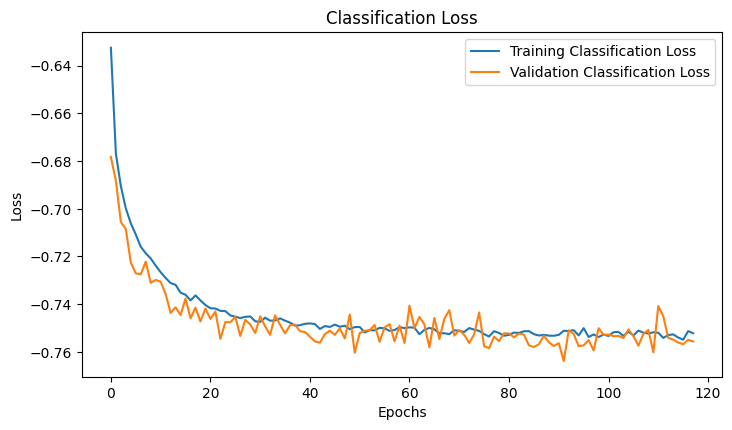

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']
reconstruction_loss = history.history['reconstruction_reconstruction_loss']
val_reconstruction_loss = history.history['val_reconstruction_reconstruction_loss']
classification_loss = history.history['softmax_output_dependency_criterion']
val_classification_loss = history.history['val_softmax_output_dependency_criterion']
dkl_loss = history.history['z_gaussian_dkl_loss']
val_dkl_loss = history.history['val_z_gaussian_dkl_loss']

plt.figure(figsize=(14, 8))



# Gráfico para la pérdida de clasificación
plt.subplot(2, 2, 3)
plt.plot(classification_loss, label='Training Classification Loss')
plt.plot(val_classification_loss, label='Validation Classification Loss')
plt.title('Classification Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()



# Mostrar los gráficos
plt.tight_layout()
plt.show()

In [16]:
# Predicciones de clasificación
softmax_output = X_re[2]  
predicted_labels = np.argmax(softmax_output, axis=1)

accuracy = accuracy_score(y_test, predicted_labels)
print("Accuracy:", accuracy)
print(classification_report(y_test, predicted_labels))

Accuracy: 0.8755
              precision    recall  f1-score   support

           0       0.82      0.85      0.83      1000
           1       0.97      0.97      0.97      1000
           2       0.75      0.86      0.80      1000
           3       0.87      0.89      0.88      1000
           4       0.81      0.79      0.80      1000
           5       0.98      0.93      0.96      1000
           6       0.73      0.57      0.64      1000
           7       0.94      0.94      0.94      1000
           8       0.95      0.97      0.96      1000
           9       0.92      0.97      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.87      0.88      0.87     10000
weighted avg       0.87      0.88      0.87     10000

